# Demand forecasting model evaluation and optimisation

This notebook explores the development of a Machine Learning (ML) demand forecasting model tailored to capture the seasonality, product-specific variability, and complex patterns present in a preprocessed dataset.

In [69]:
import pandas as pd

# Load the preprocessed data
df = pd.read_csv('../data/processed/processed_data.csv')

## 1. Exploratory Data Analysis (EDA)

In this section, the dataset previously generated through the preprocessing pipeline is loaded and explored. 

The aim is to gain insights into demand patterns at product and category levels, identify key features for modeling, and address any imbalances or patterns in the data. These insights will guide the selection and fine-tuning of ML models for demand forecasting.

### 1.1. Data overview 

A few insights are printed.

* ***Objective:*** To undertsand the structure and characteristics of the dataset.
* ***Insights:*** 
    * The dataset contains various features related to product demand prediction, including:
        * Product-identifiying attributes (`product_id_encoded`, `category_encoded`).
        * Product characteristics (`per_item_value`, `in_stock_no_sales`).
        * Lag features (`quantity_lag_1`, `quantity_lag_7`, `quantity_lag_30`).
        * Rolling averages (`quantity_rolling_avg_7`, `quantity_rolling_avg_30`).
        * Time-related attributes (seasonality features such as `month_sin`, `month_cos`, `weekday_sin`, `weekday_cos`, and a holiday indicator `is_holiday`).
    * There are 40 categories and over 5500 products.
    * There are no missing products.

In [70]:
# Avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Display data  size, columns, and their types
print(df.info())

# Display the number of unique products and categories
num_products = df['product_id_encoded'].nunique()
num_categories = df['category_encoded'].nunique()
print(f"Number of unique products: {num_products}")
print(f"Number of unique categories: {num_categories}")

# Check for missing values
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values detected.")
else:
    print("Missing values found in the following columns:")
    print(missing[missing > 0]) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6281884 entries, 0 to 6281883
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   product_id                object 
 1   product_id_encoded        int64  
 2   product_name              object 
 3   category                  object 
 4   category_encoded          int64  
 5   quantity                  int64  
 6   per_item_value            float64
 7   in_stock                  int64  
 8   date                      object 
 9   day_offset                int64  
 10  day_of_month              int64  
 11  year                      int64  
 12  month                     int64  
 13  month_sin                 float64
 14  month_cos                 float64
 15  weekday_sin               float64
 16  weekday_cos               float64
 17  in_stock_no_sales         int64  
 18  is_holiday                int64  
 19  quantity_lag_1            int64  
 20  quantity_lag_7          

#### 1.2. Distribution of the target variable ('quantity')

The distribution of the target variable, `quantity`, which represents the demand for products, is analysed through a density plot. 

* ***Objective:*** To understand the range and variability of demand across all products.

* ***Insights:*** 
    * Most products have very low or zero quantities sold, with a sharp peak near 0.
    * This suggests a highly imbalanced dataset.

Summary statistics of 'quantity' column:
count   6281884.00
mean          1.03
std           7.35
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         498.00
Name: quantity, dtype: float64


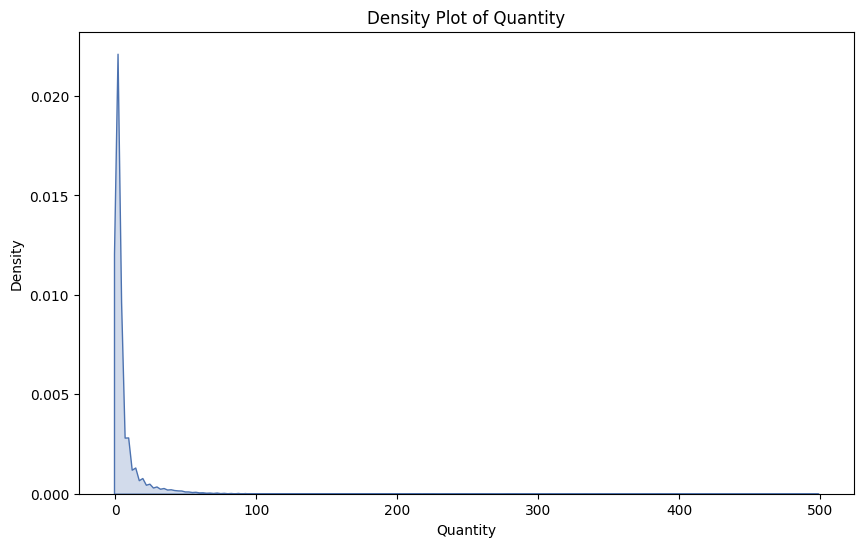

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colour palette
colours = ['#8FAADC', '#4C72B0', '#3E62A0']

# Summarise statistics of the target variable
print("Summary statistics of 'quantity' column:")
print(df['quantity'].describe())

# Plot distribution of quantity
plt.figure(figsize=(10, 6))
sns.kdeplot(df['quantity'], fill=True, color=colours[1])
plt.title('Density Plot of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

#### 1.3. Average sales per product and category

The average sales at both the product and category levels are explored through bar charts.

* ***Objective:*** To further understand the distribution of demand, helping tailor the model to capture different sales behaviors across products.
* ***Insights:*** 
    * At product level, a few products dominate sales, while others show significantly lower average sales. 
    * At category level, the variation in sales is less extreme than at the product level, suggesting more consistent demand at the category level.

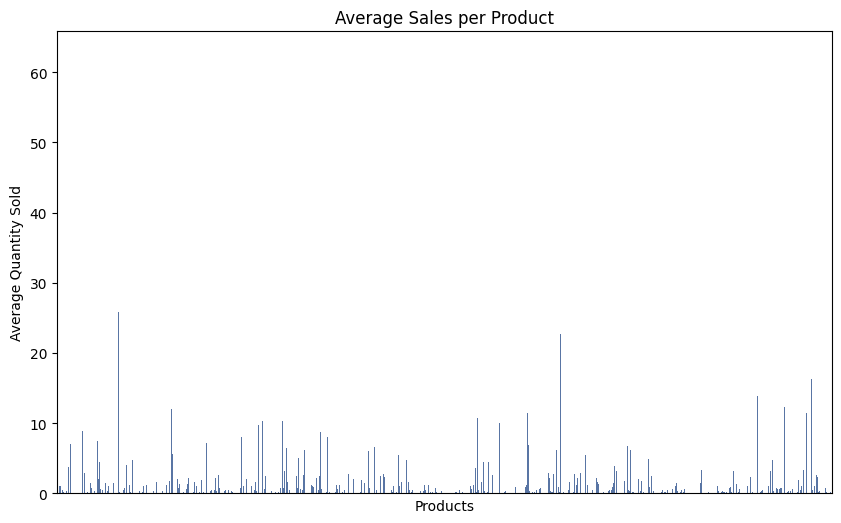

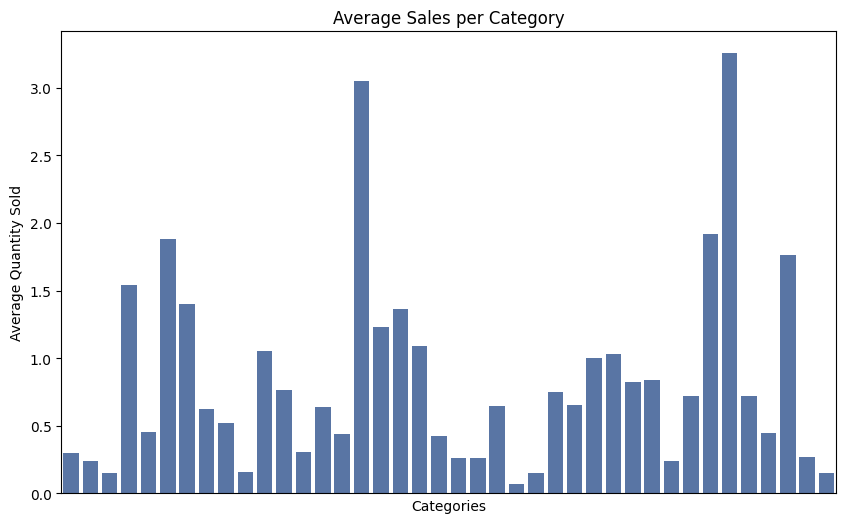

In [72]:
# Group by product and calculate average quantity sold
product_sales = df.groupby('product_id_encoded')['quantity'].mean()

# Plot average sales per product
plt.figure(figsize=(10, 6))
sns.barplot(x=product_sales.index, y=product_sales.values, color=colours[1])
plt.title('Average Sales per Product')
plt.xlabel('Products')
plt.ylabel('Average Quantity Sold')
plt.xticks([], [])  # Product IDs removed for clarity
plt.show()

# Group by category and calculate average quantity sold
category_sales = df.groupby('category_encoded')['quantity'].mean()

# Plot average sales per category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_sales.index, y=category_sales.values, color=colours[1])
plt.title('Average Sales per Category')
plt.xlabel('Categories')
plt.ylabel('Average Quantity Sold')
plt.xticks([], [])  # Category IDs removed for clarity
plt.show()

### 1.4. Sales trends over time

Sales trends are first explored by examining overall trends across months and weekdays, and then zooming in on individual product demand. 

#### 1.4.1. Overall sales trends per month and week

Average monthly and weekly sales are plotted in a time series. 

* ***Objective:*** To to observe temporal trends (e.g., seasonality or product-specific trends).
* ***Insights:***
    * Monthly, sales are low between April and August, with the highest demand in October, November, and December.
    * Weekly, sales peak on Saturday, followed by Sunday, and weekday sales patterns fluctuate across the week.
    * This trends correspond to expected lower sales during warmer months, and higher sales during the weekend.

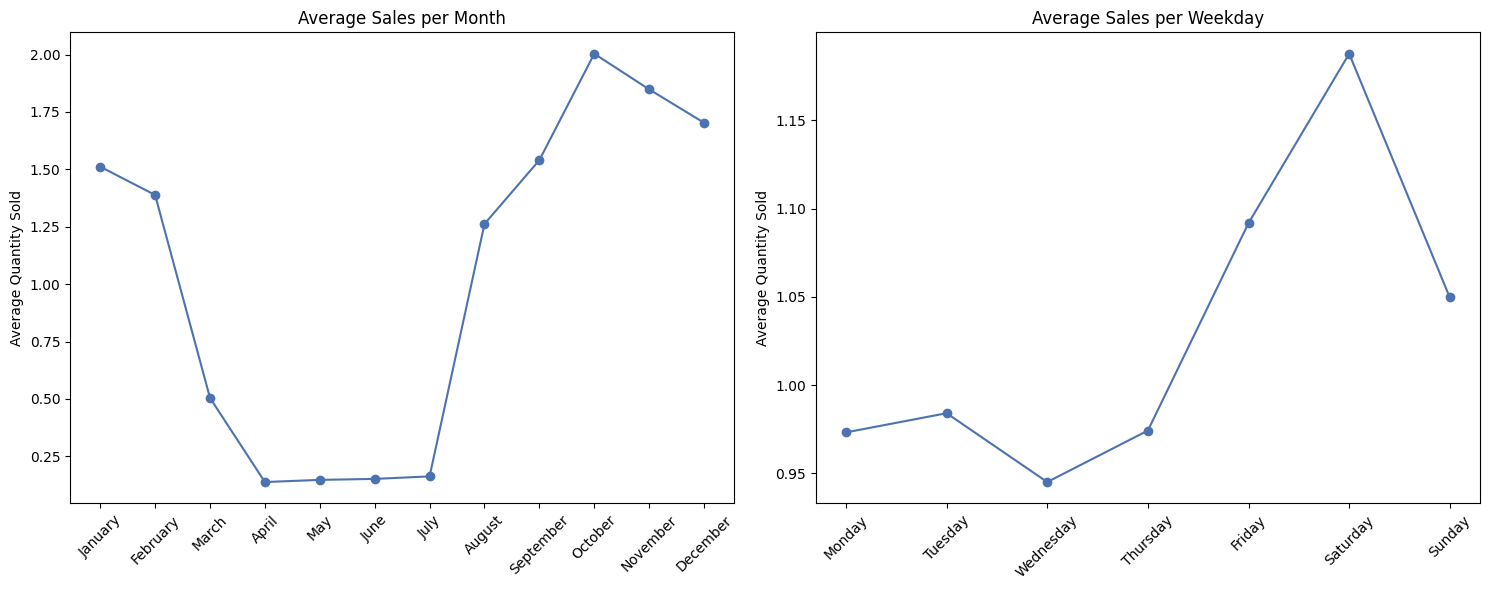

In [73]:
import calendar

# Group sales data by month and weekday 
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Ensure 'date' is in datetime format
monthly_sales = df.groupby(df['date'].dt.month)['quantity'].mean()
weekday_sales = df.groupby(df['date'].dt.weekday)['quantity'].mean()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot average sales per month
axes[0].plot(monthly_sales.index, monthly_sales.values, marker='o', color=colours[1])
axes[0].set_title('Average Sales per Month')
axes[0].set_ylabel('Average Quantity Sold')
axes[0].set_xticks(monthly_sales.index)
axes[0].set_xticklabels([calendar.month_name[i] for i in monthly_sales.index], rotation=45)

# Plot average sales per weekday
axes[1].plot(weekday_sales.index, weekday_sales.values, marker='o', color=colours[1])
axes[1].set_title('Average Sales per Weekday')
axes[1].set_ylabel('Average Quantity Sold')
axes[1].set_xticks(weekday_sales.index)
axes[1].set_xticklabels([calendar.day_name[i] for i in weekday_sales.index], rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### 1.4.2. Product-level sales trends over time

Sales trends are plotted by sales volume in a time series. Note that 3 products are selected as an example for clarity purposes.

* ***Objective:*** To further analyse demand patterns over time.
* ***Insights:***
    * **Product ID 0** shows minimal demand over time with a short single sale period recorded, potentially due to limited product availability or discontinuation.
    * **Product ID 3797** has steady demand followed by a significant spike and decline in the later months, possibly demonstarting higher demand due to a period of discounted price, popularity, etc.
    * **Product ID 3817** displays a high initial demand followed by zero sales for a period, then recovering again.    
    * These patterns show that demand is not only influenced by general trends but also varies widely at the product level.

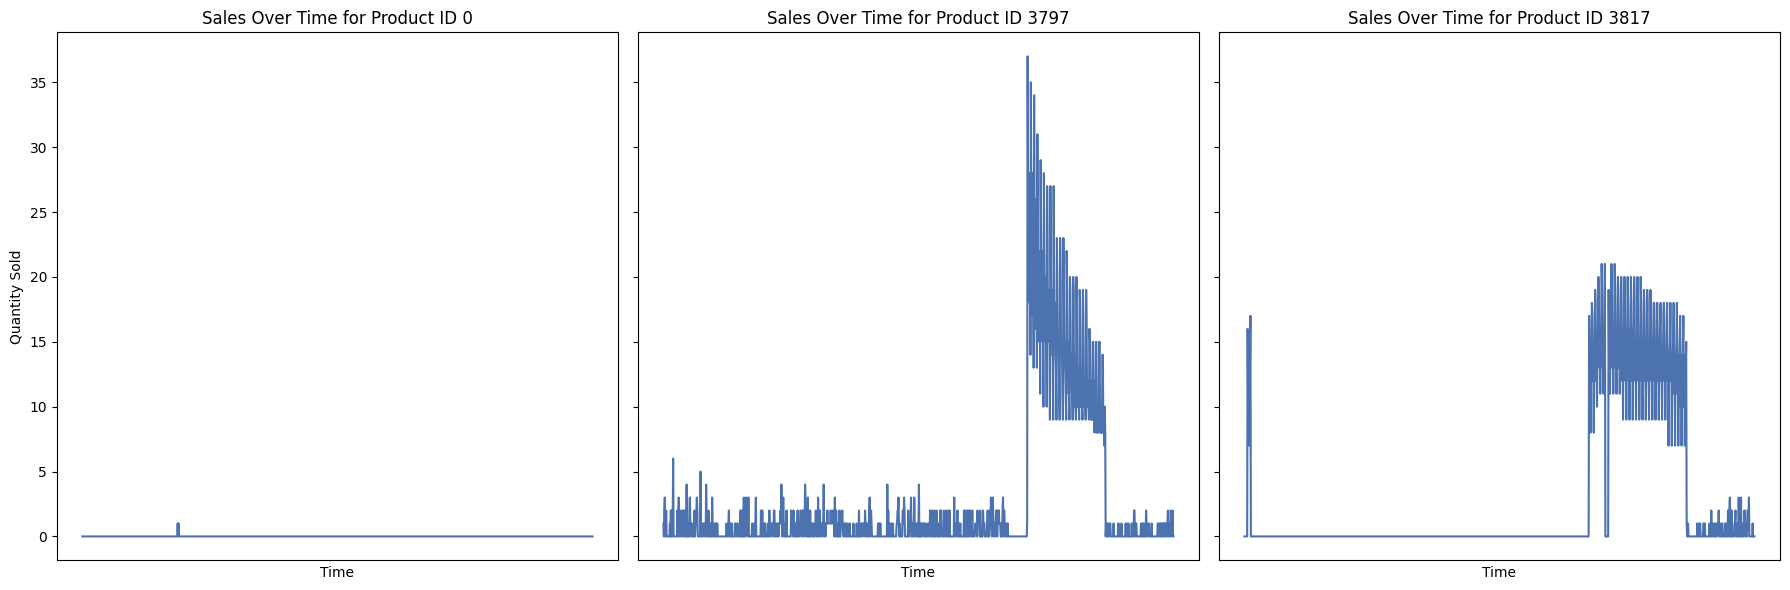

In [74]:
# Select 3 sample products
sample_products = df['product_id_encoded'].value_counts().index[:3]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot the data for each product
for i, product in enumerate(sample_products):
    product_sales = df[df['product_id_encoded'] == product].groupby('date')['quantity'].sum()
    
    axes[i].plot(product_sales.index, product_sales.values, color=colours[1])
    axes[i].set_title(f'Sales Over Time for Product ID {product}')

    # Clean labels for clear visualisation
    axes[i].set_xticks([])  # Remove x-axis labels (dates)
    if i == 0:
        axes[i].set_ylabel('Quantity Sold')  # Only set the y-axis label for the first subplot
    axes[i].set_xlabel('Time')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### 1.5. Correlation matrix of key features and quantity

Finally, correlations between key features and the target variable `quantity` are examined in a matrix.

* ***Objective:*** To identify the most predictive features.
* ***Insights:***
    * Features like quantity lags and rolling averages have strong correlations with future sales, confirming the importance of past sales data in predicting future demand.
    * Weaker correlations exist for `per_item_value`, `is_holiday`, and `in_stock_no_sales`, suggesting they may be less important for prediction.

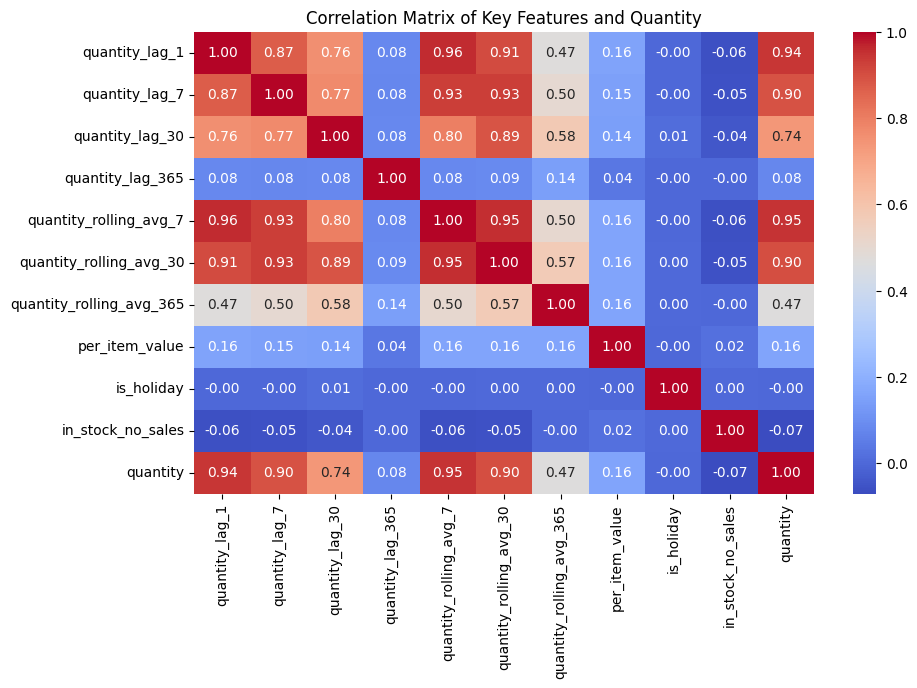

In [75]:
# Check correlations between important features and the target
features_of_interest = [
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_30', 'quantity_lag_365',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_30', 'quantity_rolling_avg_365',
    'per_item_value', 'is_holiday', 'in_stock_no_sales'
]
corr_matrix = df[features_of_interest + ['quantity']].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features and Quantity')
plt.show()

### 1.6. Key takeaways from the EDA

* **Skewed demand distribution:** The data shows significant variation in demand at all levels. This highlights the importance of regularisation to avoid overfitting in the models.

* **Clear seasonality:** The dataset exhibits strong seasonal patterns, both monthly and weekly, which must be captured in the forecasting models to improve prediction accuracy. This highlights the importance of features that capture the cyclical nature of months and weekdays (`month_sin`, `month_cos`, `weekday_sin`, and `weekday_cos`).

* **Strong predictive features:** Sales from previous time periods (especially the last day and week) are strong predictors of future sales, reinforcing the importance of lag features and rolling averages.

* **Low predictive power for some features:** Features like `per_item_value` and `is_holiday` show weak correlations with the target variable and are thus excluded from the feature set to reduce noise in the models.

These findings guide the decision to proceed with machine learning models that can effectively capture temporal dependencies and handle the skewed demand distribution. **XGBoost** and **LightGBM**, two powerful gradient boosting algorithms, are selected due to their ability to handle complex patterns, including seasonality and product-specific demand variability.


## 2. Feature selection and data splitting

In this section: 

* The **target** variable, `quantity`, which represents the demand for each product, is defined. 

* The relevant features are selected based on the insights from the EDA.

* The data is split into training and testing sets:

    * **Training Set:** 80% of the data is used for training purposes.
    * **Testing Set:** 20% is reserved to evaluate model performance.

* A **5% sample** from the training set is selected to explore model performance without significant computational overhead.

* Note: `random_state=42` is applied to ensure reproducibility in the train-test split and the sampling process.

In [76]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [
    'product_id_encoded', 'category_encoded', 'in_stock_no_sales',
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_30', 
    'quantity_rolling_avg_7', 'quantity_rolling_avg_30',
    'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
]

target = 'quantity'

# Extract the features (X) and target (y)
X = df[features]
y = df[target]

# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get a sample of the training variables
X_train_sample = X_train.sample(frac=0.05, random_state=42)
y_train_sample = y_train.sample(frac=0.05, random_state=42)

## 3. Hyperparameter tuning with GridSearchCV

In this section, **GridSearchCV** is implemented to systematically test combinations of hyperparameters for both the **XGBoost** and **LightGBM** models. The goal is to find the best performing hyperparameter settings for each model, improving predictive performance while minimizing overfitting.

#### ***Strategy***

* **Sample data**: The hyperparameter tuning is performed on a 5% sample of the dataset to reduce resource consumption and computational time. While there is a potential risk that tuning on a smaller sample might not fully capture the optimal parameters for the full dataset, this trade-off is necessary for efficiency. 

* **Initial broad search:** The first grid search tests a wide range of hyperparameters to identify which ranges result in better performance.

* **Refined searches:** Subsequent searches are run with hyperparameters manually refined based on the values best-performing in the previous search, gradually tuning the models. 

* **Evaluation:** 
    * During the grid searches **Mean Squared Error (MSE)** is used as the primary evaluation metric because it penalises larger errors more heavily, which is crucial for accurate demand forecasting. 
    
    * **Cross-Validation (CV)** ensures that the hyperparameters are evaluated robustly across different data subsets to avoid overfitting to specific data splits.

#### ***Key hyperparameters***

The following hyperparameters are common to both XGBoost and LightGBM models and play a key role in controlling model complexity and performance:

* `n_estimators`: Controls the number of boosting rounds (trees). Higher values allow the model to capture more patterns but may overfit.
* `learning_rate`: The step size during weight updates. A lower rate makes learning more gradual, while a higher rate increases learning speed but may risk overfitting.
* `max_depth`: Limits the depth of trees. Deeper trees can capture complex relationships, but may lead to overfitting.
* `subsample`: The fraction of training data used for each tree. Reduces overfitting by ensuring trees do not see the entire dataset.
* `colsample_bytree`: Fraction of features sampled for each tree, adding another layer of regularisation to prevent overfitting.
* `reg_alpha` and `reg_lambda`: L1 and L2 regularisation terms that directly penalise large coefficients in the model to improve generalisation and prevent overfitting.

### 3.1 XGBoost model

In addition to the shared hyperparameters, key hyperparameters tuned for the **XGBoost** model include:

* `min_child_weight`: Minimum sum of weights required to make a tree split. Larger values prevent small, weak splits, controlling tree depth.
* `gamma`: Minimum loss reduction required to make a split. Higher values encourage simpler trees and reduce overfitting.


#### 3.1.1 First grid search

In [77]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Initialise XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Define a broad hyperparameter grid
xgb_param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [3, 5],
    'gamma': [0.1, 0.2],
    'reg_alpha': [0.1, 0.3], 
    'reg_lambda': [0.1, 0.3],
}

# Perform grid search
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,  # The initialised model
    param_grid=xgb_param_grid,  # The defined grid
    scoring='neg_mean_squared_error',  # Negative MSE (minimising MSE)
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors 
    verbose=1  # Print progress
)

# Fit the grid search model
xgb_grid_search.fit(X_train_sample, y_train_sample)

# Get and print the best hyperparameters
best_xgb_params_1 = xgb_grid_search.best_params_
print("Best XGBoost parameters (round 1):")
for key, value in best_xgb_params_1.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Best XGBoost parameters (round 1):
  colsample_bytree: 1.0
  gamma: 0.2
  learning_rate: 0.1
  max_depth: 6
  min_child_weight: 3
  n_estimators: 500
  reg_alpha: 0.3
  reg_lambda: 0.3
  subsample: 0.8


#### 3.1.2 Second grid search

In [82]:
# Define a refined hyperparameter grid
xgb_refined_param_grid = {
    'n_estimators': [400, 500, 600], 
    'learning_rate': [0.07, 0.1], 
    'max_depth': [5, 6, 7], 
    'min_child_weight': [2, 3, 4], 
    'colsample_bytree': [1.0],  
    'gamma': [0.2],
    'subsample': [0.8],
    'reg_alpha': [0.2, 0.3], 
    'reg_lambda': [0.2, 0.3],
}

# Perform grid search
xgb_refined_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_refined_param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search model
xgb_refined_grid_search.fit(X_train_sample, y_train_sample)

# Get and print the best hyperparameters
best_xgb_params_2 = xgb_refined_grid_search.best_params_
print("Best XGBoost parameters (round 2):")
for key, value in best_xgb_params_2.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits


Best XGBoost parameters (round 2):
  colsample_bytree: 1.0
  gamma: 0.2
  learning_rate: 0.07
  max_depth: 7
  min_child_weight: 4
  n_estimators: 600
  reg_alpha: 0.2
  reg_lambda: 0.3
  subsample: 0.8


#### 3.1.3 Third grid search

In [83]:
# Define a further tuned hyperparameter grid
xgb_final_param_grid = {
    'n_estimators': [500, 600, 700], 
    'learning_rate': [0.06, 0.07, 0.08], 
    'min_child_weight': [3, 4, 5], 
    'colsample_bytree': [1.0],
    'gamma': [0.2],
    'subsample': [0.8],
    'max_depth': [6, 7, 8],
    'reg_alpha': [0.2], 
    'reg_lambda': [0.3],
}

# Perform the new grid search
xgb_final_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_final_param_grid,
    scoring='neg_mean_squared_error',
    cv=3, 
    n_jobs=-1,
    verbose=1
)

# Fit the grid search model
xgb_final_grid_search.fit(X_train_sample, y_train_sample)

# Get and print the best hyperparameters
best_xgb_params_3 = xgb_final_grid_search.best_params_
print("Best XGBoost parameters (round 3):")
for key, value in best_xgb_params_3.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


Best XGBoost parameters (round 3):
  colsample_bytree: 1.0
  gamma: 0.2
  learning_rate: 0.07
  max_depth: 7
  min_child_weight: 4
  n_estimators: 700
  reg_alpha: 0.2
  reg_lambda: 0.3
  subsample: 0.8


### 3.2 LightGBM

As well as the previously mentioned hyperparameters, key hyperparameters tuned for the **LightGBM** model include:

* `num_leaves`: Controls the maximum number of leaves per tree. LightGBM uses leaf-wise growth, so this parameter is critical for managing model complexity. More leaves can improve performance but also increase the risk of overfitting.
* `min_child_samples`: Similar to `min_child_weight` in **XGBoost**, this parameter controls the minimum number of data samples required to form a leaf node. It helps to regularise the model by preventing overly specific trees that overfit to the training data.

Note: the `subsample` and `colsample_bytree` values were blocked to one option from the beginning as an efficiency trade-off, prioritising the exploration of the hyperparameters that prevent overfitting as the EDA demonstrated that the data is highly skewed.

#### 3.2.1 First grid search

In [89]:
import lightgbm as lgb

# Initialise LightGBM model
lgb_model = lgb.LGBMRegressor(
    random_state=42, 
    verbose=-1
)

# Define a broad hyperparameter grid
lgb_param_grid = {
    'n_estimators': [200, 500], 
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8], 
    'num_leaves': [31, 127],
    'subsample': [0.8], 
    'colsample_bytree': [0.8],
    'min_child_samples': [50, 100],
    'reg_alpha': [0.1, 0.3],
    'reg_lambda': [0.1, 0.3],
}

# Perform grid search
lgb_grid_search = GridSearchCV(
    estimator=lgb_model,  # The initialised model
    param_grid=lgb_param_grid,  # The defined grid
    scoring='neg_mean_squared_error',  # Negative MSE (minimising MSE)
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors 
    verbose=1  # Print progress
)

# Fit the grid search model
lgb_grid_search.fit(X_train_sample, y_train_sample)

# Get and print the best hyperparameters
best_lgb_params_1 = lgb_grid_search.best_params_
print("Best LightGBM parameters (option 1):")
for key, value in best_lgb_params_1.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best LightGBM parameters (option 1):
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 8
  min_child_samples: 50
  n_estimators: 500
  num_leaves: 31
  reg_alpha: 0.3
  reg_lambda: 0.1
  subsample: 0.8


#### 3.2.2 Second grid search

In [91]:
# Define a refined hyperparameter grid
lgb_refined_param_grid = {
    'n_estimators': [400, 500, 600], 
    'learning_rate': [0.07, 0.1], 
    'max_depth': [7, 8], 
    'num_leaves': [31, 63],
    'subsample': [0.8],
    'colsample_bytree': [0.8], 
    'min_child_samples': [50, 80], 
    'reg_alpha': [0.2, 0.3], 
    'reg_lambda': [0.1, 0.2],
}

# Perform the refined grid search
lgb_refined_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_refined_param_grid,
    scoring='neg_mean_squared_error', 
    cv=3, 
    n_jobs=-1,
    verbose=1
)

# Fit the grid search model
lgb_refined_grid_search.fit(X_train_sample, y_train_sample)

# Get and print the best hyperparameters
best_lgb_params_2 = lgb_refined_grid_search.best_params_
print("Best LightGBM parameters (option 2):")
for key, value in best_lgb_params_2.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best LightGBM parameters (option 2):
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 8
  min_child_samples: 50
  n_estimators: 600
  num_leaves: 31
  reg_alpha: 0.3
  reg_lambda: 0.1
  subsample: 0.8


#### 3.2.3 Third grid search

In [92]:
# Define a hyperparameter grid
lgb_final_param_grid = {
    'n_estimators': [200, 600, 700],
    'learning_rate': [0.08, 0.1],
    'max_depth': [8, 9], 
    'num_leaves': [31], 
    'subsample': [0.8], 
    'colsample_bytree': [0.8], 
    'min_child_samples': [50],
    'reg_alpha': [0.3], 
    'reg_lambda': [0.1], 
}

# Perform the final refinement
lgb_final_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_final_param_grid,
    scoring='neg_mean_squared_error', 
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the model with final parameters
lgb_final_grid_search.fit(X_train_sample, y_train_sample)

# Get and print the best hyperparameters
best_lgb_params_3 = lgb_final_grid_search.best_params_
print("Best LightGBM parameters (option 3):")
for key, value in best_lgb_params_3.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best LightGBM parameters (option 3):
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 8
  min_child_samples: 50
  n_estimators: 700
  num_leaves: 31
  reg_alpha: 0.3
  reg_lambda: 0.1
  subsample: 0.8


## 4. Model evaluation and comparison

This section provides an evaluation framework for comparing model performance on the full dataset. Several key functions are defined to calculate various performance metrics and generate visualisations, enabling a thorough comparison across different models.

#### ***Metrics***

The following key metrics are used to evaluate model performance:

* **Mean Absolute Error (MAE):** Measures the average magnitude of prediction errors, with lower values indicating better accuracy.

* **Mean Squared Error (MSE):** Penalises larger errors more heavily, so lower values are preferred to minimise the impact of large prediction deviations.

* **Root Mean Squared Error (RMSE):** A scaled version of MSE, offering an intuitive measure of prediction error in the original scale of the target variable, with lower values indicating better predictive performance.

* **R-squared (R²):** Indicates the proportion of variance explained by the model, with values closer to 1 showing better performance.

* **Cross-Validation MSE (CV MSE):** Assesses how well the model generalises across different parts of the training data using 3-fold cross-validation, with a lower CV MSE indicating better generalisation and stability.

* **Standard deviation of CV MSE:** Measures the variability of the CV MSE across the different folds, with a narrower standard deviation indicating more consistent model performance across the dataset, i.e., less likelihood of overfitting.

#### ***Weighted score***

A custom **weighted score** combines the metrics based on their importance for demand forecasting:

* **RMSE (40%):** Focuses on minimising large errors, critical for accurate demand forecasting.
* **R-squared (30%):** Emphasises explaining variance in demand, helping to ensure the model is capturing key demand trends.
* **MAE (20%):** Measures the average error magnitude, providing an overall indication of prediction accuracy, without being overly sensitive to outliers.
* **MSE (10%):** Complements RMSE but is less emphasised since RMSE is a more interpretable metric due to its scale.

This score is crucial as it balances the need to minimise large errors (via RMSE), explain variability (R²), and maintain overall prediction accuracy (MAE), and offers an easily interpretable value — the lower weighted score, the better.

#### ***Visualisations***

The following visual aids are provided to compare models:

* **Bar Charts:** Compare **MAE, MSE, RMSE,** and **R²** metrics side by side.

* **CV MSE Plot:** Visualises the **CV MSE** and its **standard deviation** to assess generalisation ability.

* A **comparison table** summarises the metrics, offering an at-a-glance comparison of model performance.

In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Dynamically return the appropriate model
def get_model(model_type, params):
    if model_type == 'XGBoost':
        return xgb.XGBRegressor(random_state=42, **params)
    elif model_type == 'LightGBM':
        return lgb.LGBMRegressor(random_state=42, **params)
    else:
        raise ValueError("Invalid model type.")
    
# Train the model and return predictions
def train_model(model_type, params, X_train, y_train, X_test):
    model = get_model(model_type, params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred

# Calculate a weighted score for each model based on the metrics
def calculate_weighted_score(mae, mse, rmse, r2, weights = {'mae': 0.2, 'mse': 0.1, 'rmse': 0.4, 'r2': 0.3}):
    return (weights['mae'] * mae +
            weights['mse'] * mse +
            weights['rmse'] * rmse +
            weights['r2'] * (1 - r2))  # R² closer to 1 is better, so subtract it from 1


# Evaluate a model's performance
def evaluate_model_performance(y_test, y_pred, X_train, y_train, model):
    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation for robustness
    cross_val_mse = -np.mean(cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3))
    cross_val_r2 = np.mean(cross_val_score(model, X_train, y_train, scoring='r2', cv=3))
    cv_stddev_mse = np.std(cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3))

    # Calculate the weighted score
    weighted_score = calculate_weighted_score(mae, mse, rmse, r2)

    return mae, mse, rmse, r2, weighted_score, cross_val_mse, cv_stddev_mse, cross_val_r2

# Evaluate multiple models
def evaluate_models(model_type, best_models_params, X_train, X_test, y_train, y_test):
    metrics = []
    trained_models = []

    for i, params in enumerate(best_models_params):
        # Train the model and get predictions
        model, y_pred = train_model(model_type, params, X_train, y_train, X_test)
        
        # Evaluate the performance
        mae, mse, rmse, r2, weighted_score, cross_val_mse, cv_stddev_mse, cross_val_r2 = evaluate_model_performance(
            y_test, y_pred, X_train, y_train, model
        )
        
        # Save the results
        metrics.append([f"{model_type} Model {i + 1}", mae, mse, rmse, r2, weighted_score, cross_val_mse, cv_stddev_mse, cross_val_r2])
        
        # Save the trained model
        trained_models.append(model) 

    return metrics, trained_models

# Plot bar charts
def plot_barcharts(metrics_df):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    plt.title('Metrics per Model')

    # Bar plot for MAE
    axes[0].bar(metrics_df['Model'], metrics_df['MAE'], color=colours)
    axes[0].set_title('Mean Absolute Error (MAE)')
    axes[0].set_ylabel('MAE')

    # Bar plot for MSE
    axes[1].bar(metrics_df['Model'], metrics_df['MSE'], color=colours)
    axes[1].set_title('Mean Squared Error (MSE)')
    axes[1].set_ylabel('MSE')

    # Bar plot for RMSE
    axes[2].bar(metrics_df['Model'], metrics_df['RMSE'], color=colours)
    axes[2].set_title('Root Mean Squared Error (RMSE)')
    axes[2].set_ylabel('RMSE')

    # Bar plot for R-squared
    axes[3].bar(metrics_df['Model'], metrics_df['R²'], color=colours)
    axes[3].set_title('R-squared (R²)')
    axes[3].set_ylabel('R²')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot cross-validation performance and weighted score side by side
def plot_linecharts(metrics_df):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot cross-validation MSE with Std. Dev.
    axes[0].plot(metrics_df['Model'], metrics_df['CV MSE'], marker='o', linestyle='-', color='r', label='CV MSE')
    axes[0].fill_between(metrics_df['Model'], metrics_df['CV MSE'] - metrics_df['CV MSE Std. Dev.'], 
                         metrics_df['CV MSE'] + metrics_df['CV MSE Std. Dev.'], color=colours[0], alpha=0.3, label='MSE Std. Dev.')
    axes[0].set_title('Cross-Validation MSE with Std. Dev.')
    axes[0].set_ylabel('MSE')
    axes[0].legend()

    # Plot the weighted score
    axes[1].plot(metrics_df['Model'], metrics_df['Weighted Score'], marker='o', linestyle='-', color=colours[1])
    axes[1].set_title('Weighted Score per Model')
    axes[1].set_ylabel('Weighted Score')

    plt.tight_layout()
    plt.show()

# Provide a comparison of all metrics
def compare_model_metrics(metrics_df):

    # Plot metrics
    plot_barcharts(metrics_df)
    plot_linecharts(metrics_df)
    
    # Display the comparison table
    print(metrics_df)

### 4.1 XGBoost model evaluation

This section evaluates the top three **XGBoost** models identified during hyperparameter tuning using the evaluation framework described above. 

#### ***Key findings***

* Model 3 achieves the lowest **MAE, MSE** and **RMSE**.
* All models have similar **R²** values.
* Model 3 also has the lowest **CV MSE**.
* While Model 1 has the lowest **standard deviation of the CV MSE**, the differences across all models are relatively small.
* Model 3 achieves the lowest **weighted score**.

#### ***Best model***

Based on the evaluation of the above metrics, **XGBoost Model 3** is identified as the best-performing model.

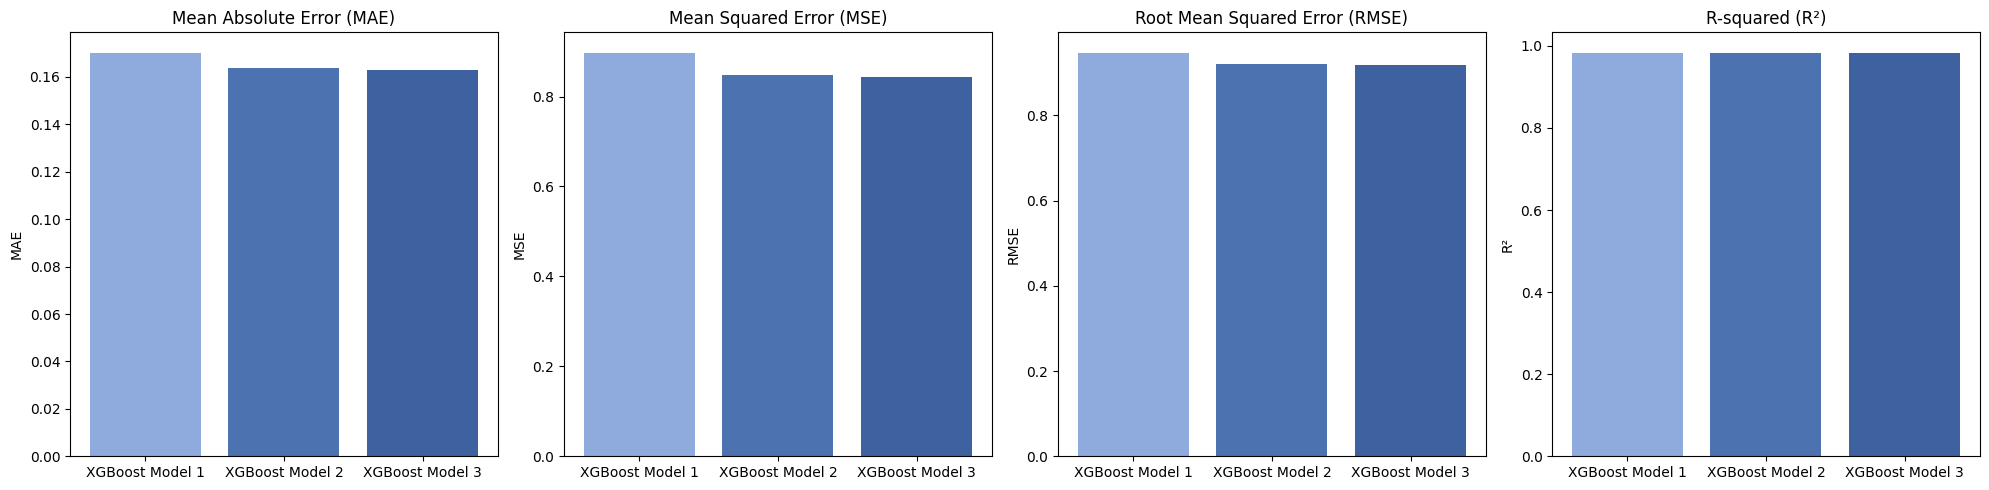

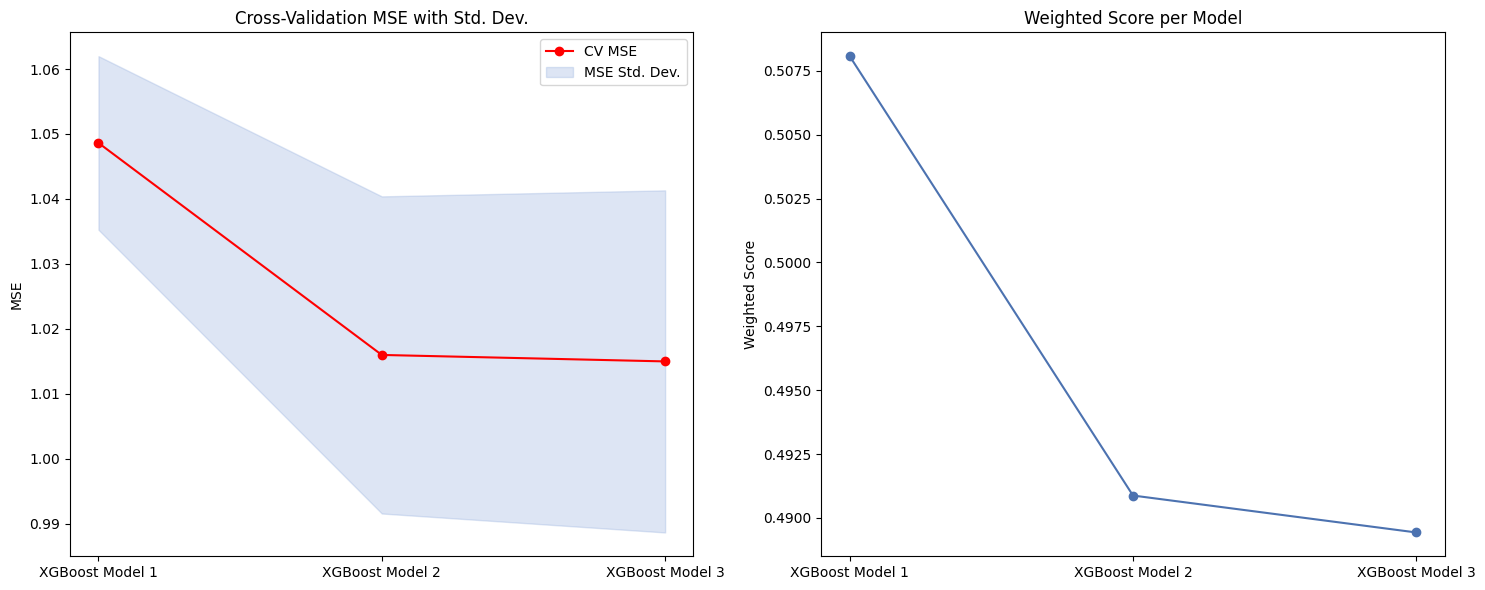

             Model  MAE  MSE  RMSE   R²  Weighted Score  CV MSE  \
0  XGBoost Model 1 0.17 0.90  0.95 0.98            0.51    1.05   
1  XGBoost Model 2 0.16 0.85  0.92 0.98            0.49    1.02   
2  XGBoost Model 3 0.16 0.84  0.92 0.98            0.49    1.01   

   CV MSE Std. Dev.  CV R²  
0              0.01   0.98  
1              0.02   0.98  
2              0.03   0.98  


In [94]:
# Collect the best hyperparameter settings
xgb_models_params = [best_xgb_params_1, best_xgb_params_2, best_xgb_params_3]

# Evaluate the models 
xgb_metrics, xgb_models = evaluate_models('XGBoost', xgb_models_params, X_train, X_test, y_train, y_test)

# Convert to DataFrame
xgb_metrics_df = pd.DataFrame(xgb_metrics, columns=["Model", "MAE", "MSE", "RMSE", "R²", "Weighted Score", "CV MSE", "CV MSE Std. Dev.", "CV R²"])

# Compare the metrics
compare_model_metrics(xgb_metrics_df)

### 4.2 LightGBM model evaluation

This section evaluates the top three **LightGBM** models identified during hyperparameter tuning using the evaluation framework described above. 

#### ***Key findings***

* Model 3 achieves the lowest **MAE**, **MSE**, and **RMSE**.
* All models have identical **R²** values.
* Model 3 has the lowest **CV MSE**.
* The **standard deviation of the CV MSE** is the same across all models.
* Model 3 also achieves the lowest **weighted score**.

#### ***Best model***

Based on the evaluation of the above metrics, LightGBM Model 3 is identified as the best-performing model.

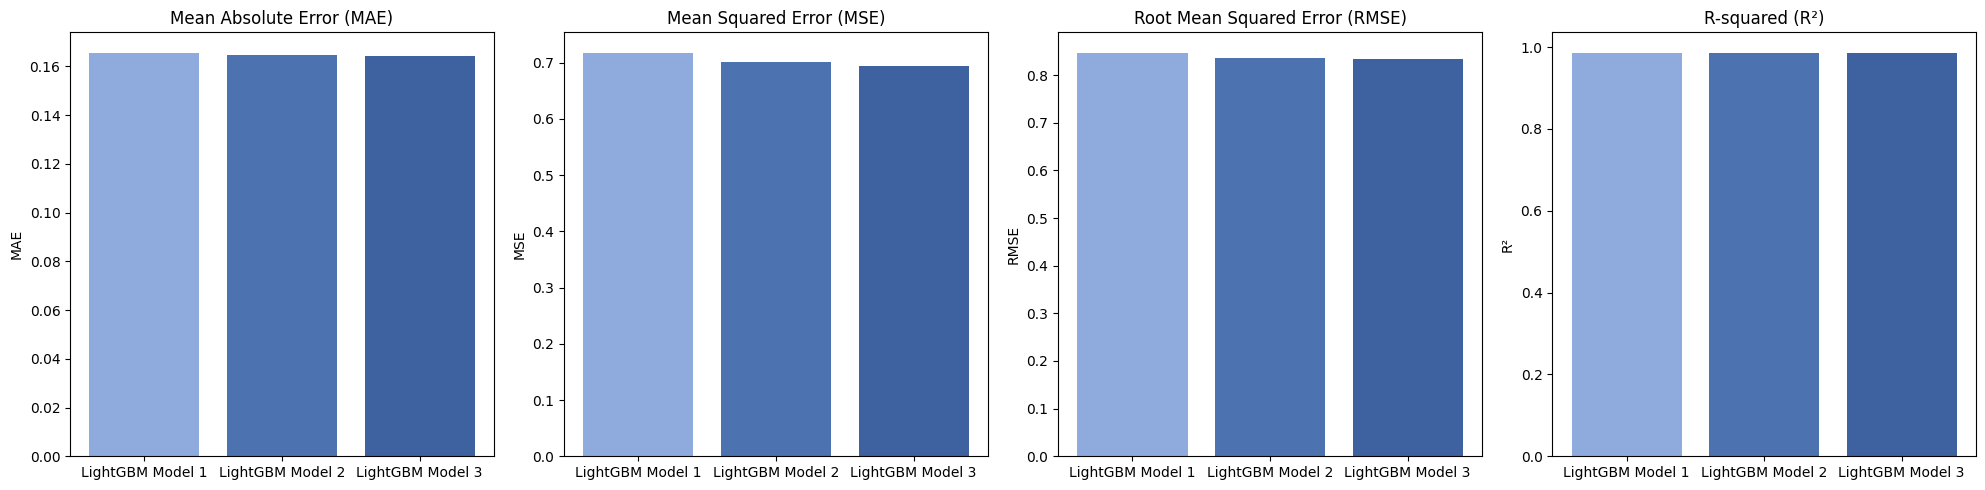

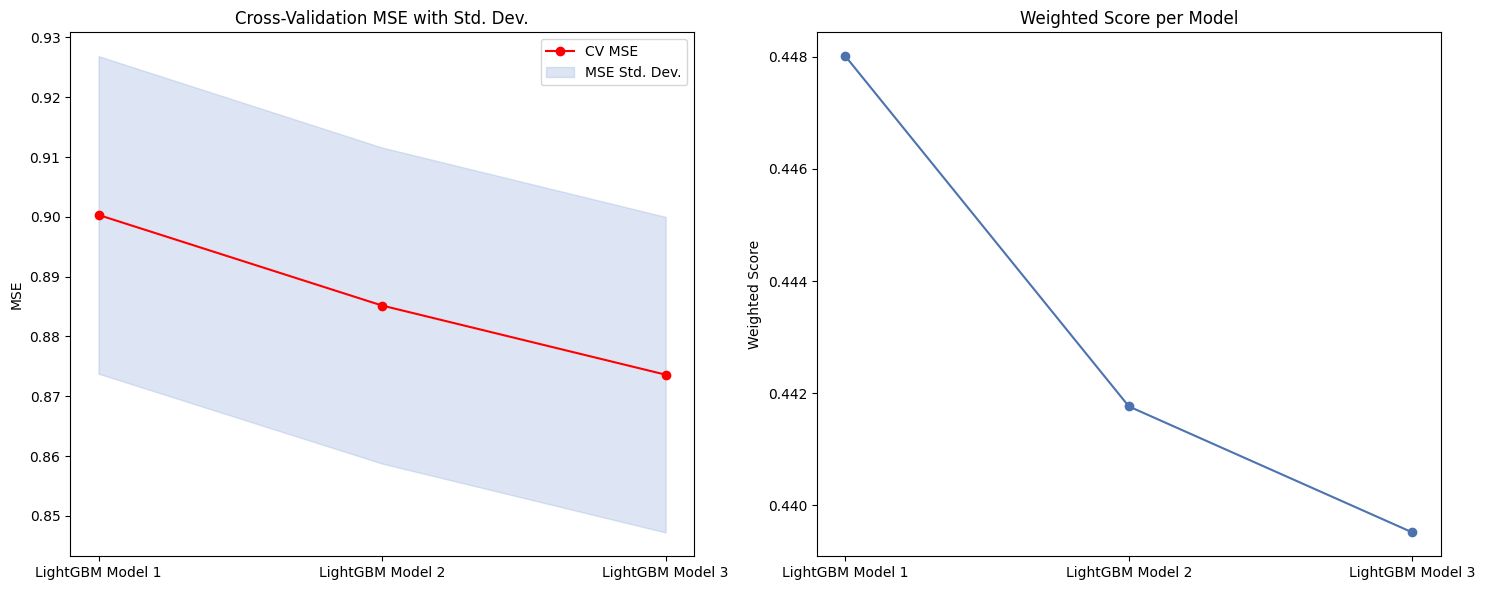

              Model  MAE  MSE  RMSE   R²  Weighted Score  CV MSE  \
0  LightGBM Model 1 0.17 0.72  0.85 0.99            0.45    0.90   
1  LightGBM Model 2 0.16 0.70  0.84 0.99            0.44    0.89   
2  LightGBM Model 3 0.16 0.69  0.83 0.99            0.44    0.87   

   CV MSE Std. Dev.  CV R²  
0              0.03   0.98  
1              0.03   0.98  
2              0.03   0.98  


In [95]:
# Collect the best hyperparameter settings
lgb_models_params = [best_lgb_params_1, best_lgb_params_2, best_lgb_params_3]

# Evaluate the models
lgb_metrics, lgb_models = evaluate_models('LightGBM', lgb_models_params, X_train, X_test, y_train, y_test)

# Convert to DataFrame
lgb_metrics_df = pd.DataFrame(lgb_metrics, columns=["Model", "MAE", "MSE", "RMSE", "R²", "Weighted Score", "CV MSE", "CV MSE Std. Dev.", "CV R²"])

# Compare the metrics
compare_model_metrics(lgb_metrics_df)

### 4.3 XGBoost vs LightGBM

This section compares the best-performing **XGBoost** model - Model 3 - and the best-performing **LightGBM** model - Model 3 - to determine the overall superior model for this demand forecasting task. 

The comparison is carried out by leveraging the previously obtained evaluation metrics for these models (without needing to re-run the evaluation). 

Additionally, feature importance is plotted for both models to gain a deeper insight into how each model prioritises the different features when predicting demand, further informing the final model selection.

#### ***Key findings***

* Both models have an identical **MAE**.
* The **LightGBM** model achieves significantly lower **MSE** and **RMSE** compared to the **XGBoost** model.
* Both models have the same **R²** values.
* The **LightGBM** model has a lower **CV MSE**.
* The **standard deviation of the CV MSE** is identical for both models.
* The **LightGBM** model achieves the lowest **weighted score**.
* In terms of **feature importance**:
    * **XGBoost** heavily emphasizes `product_id_encoded`, highlighting its focus on product-specific predictions.
    * **LightGBM**  distributes importance more evenly across time-series lag features, capturing both short-term and long-term demand patterns. Although **LightGBM** places less importance on `product_id_encoded`, it still uses the feature effectively.

#### ***Best final model***

**LightGBM** outperforms **XGBoost** in terms of **MSE, RMSE, CV MSE**, and **weighted score**, which suggests **LightGBM** is better at generalising and minimising large prediction errors.

However, **XGBoost** assigns significantly more importance to the `product_id_encoded` feature, which is crucial for this project, as accurate product-level predictions are essential in an inventory management system.

Given that product-specific demand accuracy is a top priority and the performance differences between the models are relatively narrow, the **XGBoost** model will be implemented first. Furthermore, if the results do not meet expectations, switching to the **LightGBM** model will be considered.

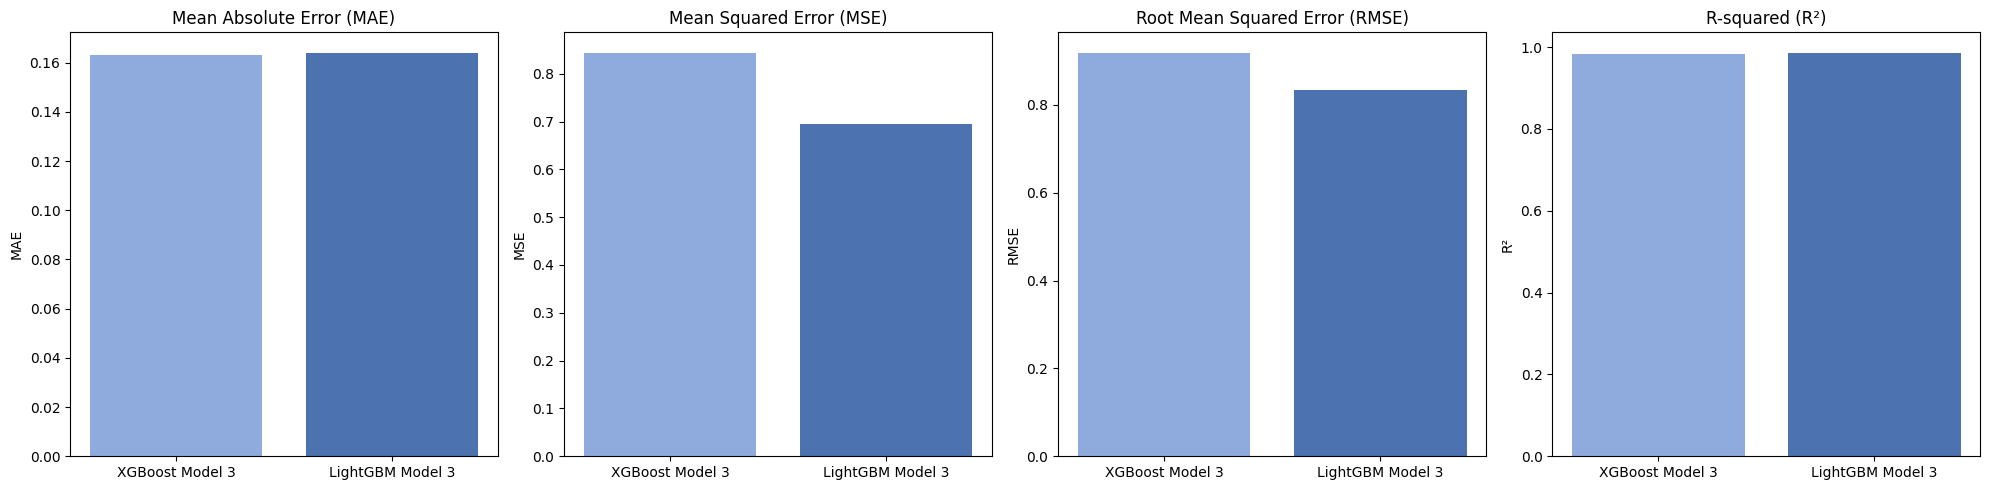

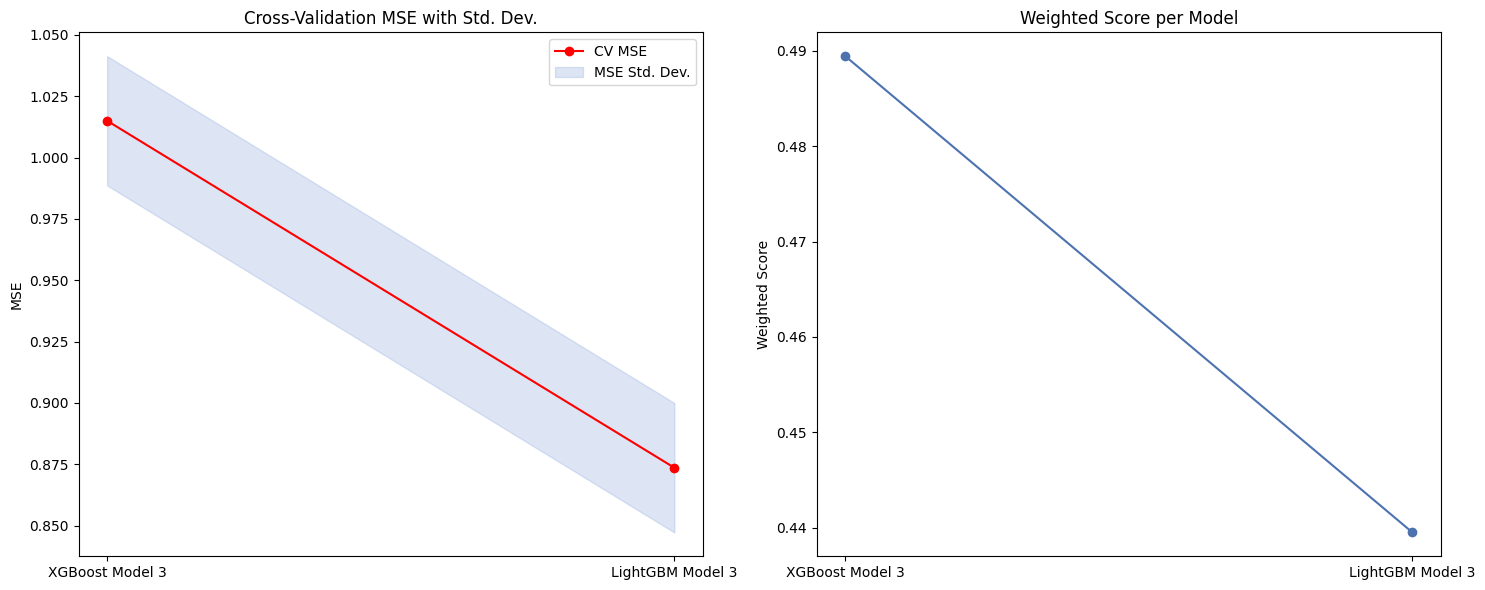

              Model  MAE  MSE  RMSE   R²  Weighted Score  CV MSE  \
0   XGBoost Model 3 0.16 0.84  0.92 0.98            0.49    1.01   
0  LightGBM Model 3 0.16 0.69  0.83 0.99            0.44    0.87   

   CV MSE Std. Dev.  CV R²  
0              0.03   0.98  
0              0.03   0.98  


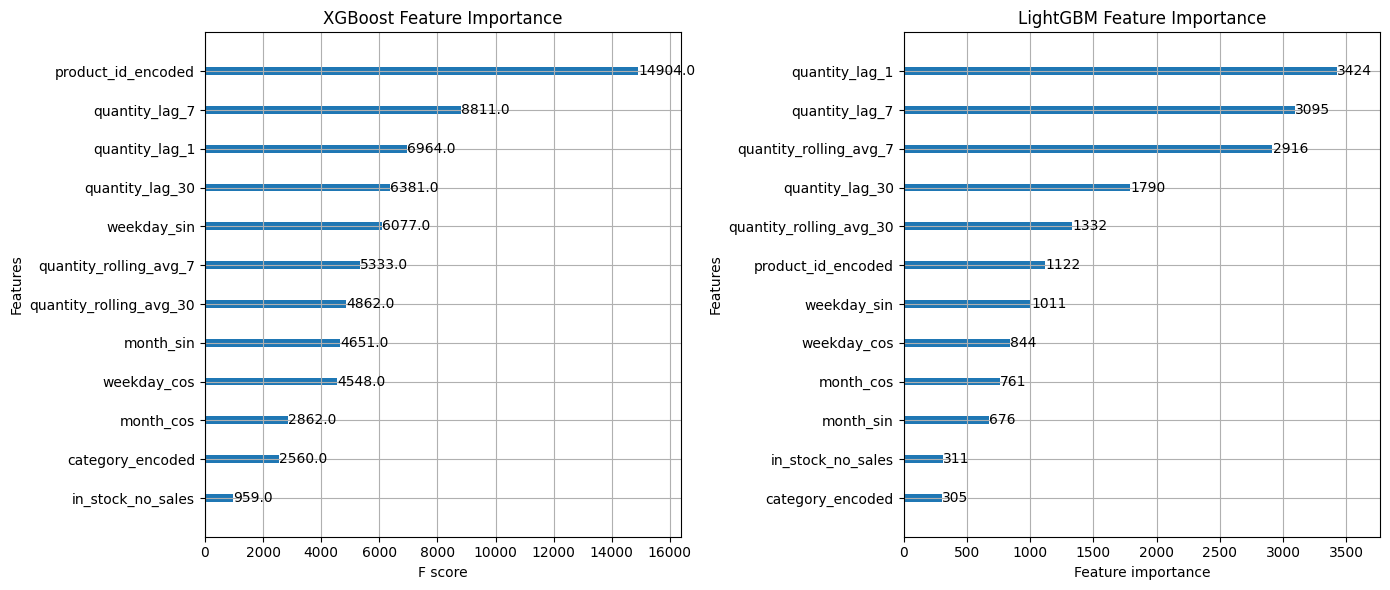

In [99]:
# Collect the metrics from the selected best XGboost and LightGBM models
best_xgb_df = pd.DataFrame([xgb_metrics[2]], columns=["Model", "MAE", "MSE", "RMSE", "R²", "Weighted Score", "CV MSE", "CV MSE Std. Dev.", "CV R²"])
best_lgb_df = pd.DataFrame([lgb_metrics[2]], columns=["Model", "MAE", "MSE", "RMSE", "R²", "Weighted Score", "CV MSE", "CV MSE Std. Dev.", "CV R²"])

# Combine the two into one DataFrame
xgb_vs_lgb_metrics_df = pd.concat([best_xgb_df, best_lgb_df])

# Compare the metrics
compare_model_metrics(xgb_vs_lgb_metrics_df)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot XGBoost feature importance
xgb.plot_importance(xgb_models[2], ax=axes[0])
axes[0].set_title('XGBoost Feature Importance')

# Plot LightGBM feature importance
lgb.plot_importance(lgb_models[2], ax=axes[1])
axes[1].set_title('LightGBM Feature Importance')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()